# ENSO Recharge Oscillator Practical: Simulations and Forecasting

This notebook serves as the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). It covers both theoretical and computational aspects of the RO framework, demonstrating its applications in ENSO simulations and forecasting.

**Instructors**
- **Sen Zhao** (<zhaos@hawaii.edu>)
- **Soong-Ki Kim** (<sskk503@yonsei.ac.kr>)
- **Jérôme Vialard** (<jerome.vialard@ird.fr>)

---

### Overview

In this notebook, we will demonstrate how to use the `XRO` framework for **Recharge-Oscillator (RO) model** fitting, simulations, and reforecasting.

***Extended Nonlinear Recharge Oscillator (XRO) framework***

The `XRO` framework was developed to investigate the role of climate mode interactions in ENSO dynamics and predictability ([Zhao et al. 2024](https://doi.org/10.1038/s41586-024-07534-6)). When other climate modes are not considered, it simplifies to the Recharge Oscillator (RO), making it well-suited for use in this practical context. We have designed `XRO` to be user-friendly, aiming to be a valuable tool not only for research but also for operational forecasting and as an educational resource in the classroom.

> Check out the updated version of XRO at https://github.com/senclimate/XRO


***Community Recharge Oscillator (CRO) model framework***

The `CRO` code package is an easy-to-use Python/MATLAB software for solving and fitting the ENSO RO model. The `CRO` code is currently under development and is planned for release in 2025. The distributed version for the ENSO Winter School 2025 is a light Python version that includes only the essential features. While we introduce the `CRO` framework in this practical, some of its functionalities are unavailable. Therefore, for consistency, we will primarily use the `XRO` framework.

For those interested in the `CRO` code, please refer to the Jupyter notebook:  
📂 *CRO_test/RO_Practical_with_CRO_Framework.ipynb*

Special thanks to **Bastien Pagli** for providing the original `CRO` code in Python.

---

### Run it at Google Colab
You can easily run this notebook on [Google Colab](https://colab.research.google.com/). 

Simply download [this notebook](RO_parctical_with_XRO_framework.ipynb) and upload it to Google Colab. 

Once uploaded, you can execute the notebook directly— all required data and Python libraries will be downloaded and installed automatically.


Load basic python libraries
Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
import warnings

In [2]:
# Import necessary modules after ensuring files are available
from src.XRO import XRO, xcorr
from src.XRO_utils import (
    SkewAccessor,
    plot_above_below_shading,
    plot_fill_between,
    pmtm,
)

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 1. Observed ENSO properties related to RO

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).


In [3]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_file = "../data/XRO_indices_oras5.nc"

obs_ds = xr.open_dataset(obs_file).sel(time=slice("1979-01", "2024-12"))
obs_RO_ds = obs_ds[["Nino34", "WWV"]]
print(obs_RO_ds)

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 2kB ...
Data variables:
    Nino34   (time) float32 2kB ...
    WWV      (time) float32 2kB ...


### 1.1 ENSO time series

Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

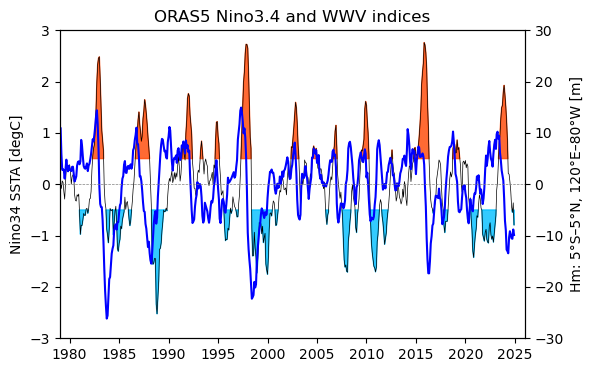

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plot_above_below_shading(
    obs_RO_ds["Nino34"],
    xtime=obs_RO_ds.time,
    c="black",
    lw=0.5,
    above=0.5,
    above_c="orangered",
    below=-0.5,
    below_c="deepskyblue",
    ax=ax,
)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel("Nino34 SSTA [degC]")

axR = ax.twinx()
obs_RO_ds["WWV"].plot(ax=axR, c="blue", lw=1.5)
axR.set_ylim([-30, 30])
axR.axhline(0, ls="--", c="gray", lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title("ORAS5 Nino3.4 and WWV indices")

## Look at parameter variation over time

#### Fit model to 20-yr rolling windows

In [5]:
## Get number of timesteps in data
n = len(obs_RO_ds.time)

## specify number of samples to use in each window
window_size = 240  # units: months

## empty list to hold results and dates
params_by_year = []
start_dates = []

## loop through rolling windows
with warnings.catch_warnings(action="ignore"):
    for i in np.arange(0, n - 12, 12):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = obs_RO_ds.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## initialize model
            model = XRO(ncycle=12, ac_order=1, is_forward=True)

            ## fit matrix and get parameters
            fit_LRO = model.fit_matrix(data_subset, maskNT=[], maskNH=[])
            params_by_year.append(model.get_RO_parameters(fit_LRO))

## convert from list to xarray
start_dates = xr.concat(start_dates, dim="time")
params_by_year = xr.concat(params_by_year, dim=start_dates)

#### Plot annual-mean $R$ parameter

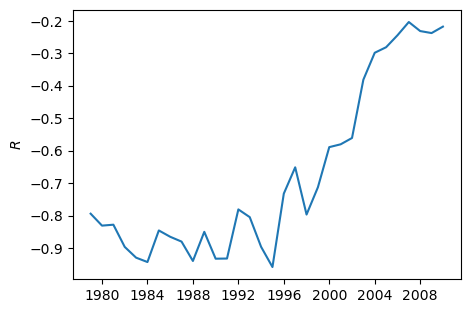

In [6]:
## plot annual mean growth rate
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(params_by_year.time, params_by_year["R"].mean("cycle"))
ax.set_ylabel(r"$R$")
plt.show()